最大收益率出现在设置定投频率为36日时
总投资： 128500.0
总收益： 22535.332355194918
收益率:  17.53722362271978 %


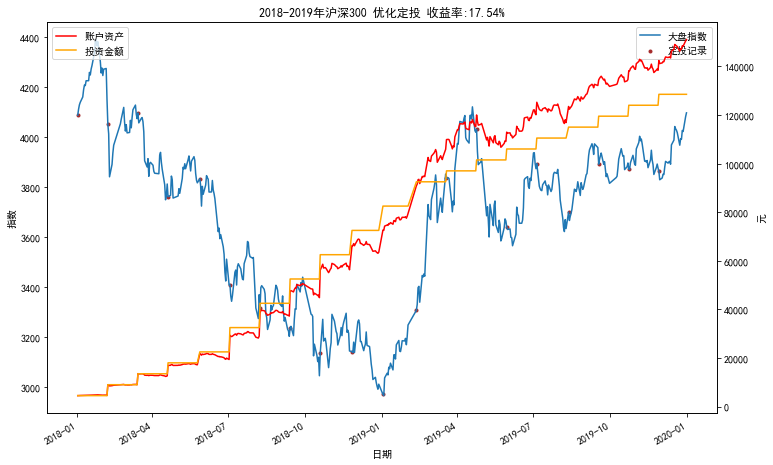

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import warnings
import execjs
import datetime,time

warnings.filterwarnings('ignore')
plt.rcParams['font.family']='SimHei'
plt.rcParams['axes.unicode_minus']=False
plt.rcParams['figure.figsize']=(12,8)


def get_data(code,start,end):
    '''
    获取指定时间范围的股票数据
    :param code: 指数代码
    :param start: 起始日期
    :param end: 截止日期
    :return: DataFrame
    '''
    url='http://quotes.money.163.com/service/chddata.html?code={}&start={}&end={}&fields=TCLOSE;HIGH;LOW;TOPEN;LCLOSE;CHG;PCHG;VOTURNOVER;VATURNOVER'.format(code,start,end)
    name=code+'_'+start+"-"+end
    f=open(name,'wb')
    f.write(requests.get(url).content)
    f.close()
    data=pd.read_csv(name,encoding='gbk')
    return data

def clean_data(data):
    '''
    1、将日期转换为时间序列并设置为索引
    2、将数据按时间序列升序排序
    3、删除缺失值
    4、将涨跌幅的单位转换为小数
    
    '''
    data['日期']=pd.to_datetime(data['日期'])
    data=data.set_index("日期")
    data=data.sort_index()
    data.drop(data[data["涨跌幅"]=="None"].index,axis=0,inplace=True)
    data["涨跌幅"]=data['涨跌幅'].astype('float')
    data['涨跌幅']/=100
    return data

df3=get_data('0000300','20210801','20220820')
df3=clean_data(df3)

def mean_days(df,days,wave):
    '''
     获取n日均线,最近m日振幅
    :param df: 数据集
    :param days: 均线天数
    :params wave:最近m日振幅
    :return average,wavelength:均线、近m日振幅
    '''
    average=[]
    wavelength=[]
    start=df.head(1).index-np.timedelta64(days+1,"D")
    start=start.astype('str')[0].replace("-","")#转换为字符串
    
    df4=get_data('0000300',start,'20220820')#获得原始数据前days天的数据用以求均值
    df4=clean_data(df4)
    for i in df3.index:
        start_date=i-np.timedelta64(days+1,"D")
        ave=df4[(df4.index>start_date) & (df4.index<i)]['收盘价'].mean()
        average.append(ave)
    ########求振幅#######
    start2=df.head(1).index-np.timedelta64(wave+1,"D")
    start2=start2.astype('str')[0].replace("-","")#转换为字符串
    df5=get_data('0000300',start2,'20220820')
    df5=clean_data(df5)
    
    for i in df3.index:
        start_date=i-np.timedelta64(wave+1,"D")
        interval=df5[(df5.index>start_date) & (df5.index<i)]['收盘价']
        length=interval.max()/interval.min()-1#最大涨跌幅
        wavelength.append(length)
        
    return average,wavelength

def stratege(ml,wl,T_1):
    '''
    定投策略
    :param ml:均线
    :param wl:振幅
    :param T_1:前1日收盘价
    '''
    cal=T_1/ml-1#大于0,则高于均线
    if(cal>=0 and cal<0.15):
        return 0.9
    elif(cal>0.15 and cal<0.5):
        return 0.8
    elif(cal>=0.5 and cal<1):
        return 0.7
    elif(cal>=1):
        return 0.6
    
    elif(wl>0.05):
        
        if(cal>=-0.05 and cal<0):
            return 0.6
        elif(cal>=-0.1 and cal<-0.05):
            return 0.7
        elif(cal>=-0.2 and cal<-0.1):
            return 0.8
        elif(cal>=-0.3 and cal<-0.2):
            return 0.9
        elif(cal>=-0.4 and cal<-0.3):
            return 1.0
        elif(cal<-0.4):
            return 1.1
    else:
        if(cal>=-0.05 and cal<0):
            return 1.8
        elif(cal>=-0.1 and cal<-0.05):
            return 1.9
        elif(cal>=-0.2 and cal<-0.1):
            return 2.0
        elif(cal>=-0.3 and cal<-0.2):
            return 2.1
        elif(cal>=-0.4 and cal<-0.3):
            return 2.2
        elif(cal<-0.4):
            return 2.3

def smart_invest(df1,frequence,invest_money,start_time,days,wave):
    '''
     定投计算
    :param df1: 数据集
    :param frequence: 定投频率
    :param invest_money: 每次定投金额
    :param start: 定投起始日期
    :param days: 参考均线天数

    :return (amount,invest_log): (收益数据DataFrame，定投记录dict)
    '''
    invest_log={}#每次定投的日期记录(日期:大盘指数)
    invest_day=start_time#每次投资的时间
    invest_amount=0#总投资金额
    profile=0#总投资收益
    amount=0#账户总资产
    
    profile_log=[]#总收益日志
    invest_amount_log=[]#账户投资金额日志
    amount_log=[]#总资产日志
    Yield=[]#收益率日志
    
    df1["均线"]=mean_days(df1,days,wave)[0]#获取均线
    df1["振幅"]=mean_days(df1,days,wave)[1]#获取振幅
    for date,quote_change,index,ml,wl in zip(df1.index,df1['涨跌幅'],df1['收盘价'],df1["均线"],df1["振幅"]):
        
        profile+=quote_change*amount#计算当天收益率
        profile_log.append(profile)
        
       
        #判断是否为定投日
        if date==invest_day:
            if(invest_day==start_time):
                T_1=start_time
            else:
                formal_day=1
                while(True):
                    T_1=date-np.timedelta64(formal_day,"D")#前1天的收盘价
                    if(T_1 in df1.index.tolist()):
                        break
                    else:
                        formal_day+=1
            T_1=df1[df1.index==T_1]["收盘价"][0]
            rate=stratege(ml,wl,T_1)
            invest_amount+=invest_money*rate#定投
            invest_log[invest_day]=index#记录定投当日的指数
            
            #判断7天后是否为交易日,如果不是则往后加1天直到找到交易日
            invest_day+=np.timedelta64(frequence,'D')
            flag=0
            while(True):
                if(df1[df1.index==invest_day].index==invest_day):
                    break
                else:
                    invest_day+=np.timedelta64(1,'D')
                    flag+=1
                    if(flag==100):
                        break
                        
            
        invest_amount_log.append(invest_amount)
        amount=invest_amount+profile#更新账户总资产
        amount_log.append(amount)
        try:
            Yield.append(profile/invest_amount*100)#更新收益率
        except:
            Yield.append(0)
    print("总投资：",invest_amount)
    print("总收益：",profile)
    print("收益率: ",profile/invest_amount*100,"%")
    
    over=pd.DataFrame({
        "日期":df1.index,
        "收益率":Yield,
        "账户资产":amount_log,
        "投资金额":invest_amount_log
    })
    over=over.set_index("日期")
    return over,invest_log

def myplot(df1,res,buy,titlename):
    '''
    绘制定投结果图
    '''
    plt.figure()
    df1['收盘价'].plot(label="大盘指数")
    plt.scatter(buy.keys(),buy.values(),color="brown",marker=".",label="定投记录")
    plt.legend(loc='best')
    plt.ylabel("指数")
    plt.twinx()

    res['账户资产'].plot(color="red")
    res['投资金额'].plot(color="orange")
    plt.ylabel("元")
    plt.legend()
    plt.title(titlename+":{:.2f}%".format(res.tail(1)["收益率"][0]))
    plt.show()

frequence=36
invest_money=5000#每次定投金额
start=np.datetime64("2019-01-02")
print("最大收益率出现在设置定投频率为36日时")
res3,buy3=smart_invest(df3,frequence,invest_money,start,500,5)
myplot(df3,res3,buy3,"2018-2019年沪深300 优化定投 收益率")


In [ ]:
import execjs
import requests
import datetime,time
import pandas as pd

content = requests.get('http://fund.eastmoney.com/pingzhongdata/012414.js?v=20220821180227')
jsContent = execjs.compile(content.text)
fundAll = jsContent.eval('Data_netWorthTrend')
fundDate = []
fundWorth = []
fundTrend= []
for dayFund in fundAll:
    fundDate.append(time.strftime("%Y-%m-%d", time.localtime(dayFund['x'] / 1000)))
    fundWorth.append(dayFund['y'])
    fundTrend.append(dayFund['equityReturn'])

dataframe = pd.DataFrame({'日期':fundDate,'收盘价':fundWorth,'涨跌幅':fundTrend})
dataframe.to_csv("test.csv",index=False,sep=',')